In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import gpplot as gpp
gpp.set_aesthetics(context = 'paper')
from scipy.stats import fisher_exact

In [5]:
#read in cleaned labeled dolcetto nonessentials
noness_labeled = pd.read_csv('../../Data/externalData/Dolcetto/dolcetto_seed_score_validation_input.csv')
noness_labeled

,sgRNA Sequence,sgRNA Context Sequence,z_scored_avg_lfc,Gene ID,Target Gene Symbol,rs3ChenSeqScore,gene_avg_zscore,num_guides,promiscuous,nonpromiscuous
0,AAAAAAGATCCTCTGAGAGG,ATATAAAAAAGATCCTCTGAGAGGAGGAGG,-0.358502,221833,SP8,0.102364,0.012081,6,False,True
1,AAAAACTAGAACATACTTAA,AACAAAAAACTAGAACATACTTAATGGCAA,-0.102615,132724,TMPRSS11B,-0.077817,0.169592,5,False,True
2,AAAACAAAGGGCAAGGCCAT,CAGTAAAACAAAGGGCAAGGCCATTGGGGA,0.322584,3442,IFNA5,-0.348032,0.178252,5,False,True
3,AAAACCAAGAGCGGGTGACA,AAGGAAAACCAAGAGCGGGTGACAAGGCTG,-0.109509,1618,DAZL,0.266833,-0.416998,11,False,True
4,AAAACCAGAAAAACAATCAT,TTTAAAAACCAGAAAAACAATCATAGGTTT,0.242725,122042,RXFP2,-0.032921,0.229622,3,False,True
...,...,...,...,...,...,...,...,...,...,...
3264,TTTGGCAATCTGGGCTGACC,CTGCTTTGGCAATCTGGGCTGACCTGGCTT,0.563234,83417,FCRL4,-0.281126,-0.125570,6,False,True
3265,TTTGGCACCTCCTCCCAAGC,CCTCTTTGGCACCTCCTCCCAAGCCGGAGT,0.561931,5173,PDYN,0.030949,-0.106527,4,False,True
3266,TTTGGCTGTCCACCGAGCTC,TGGATTTGGCTGTCCACCGAGCTCCGGCGC,0.758450,129684,CNTNAP5,0.762615,-0.032726,4,False,True
3267,TTTGTCTACTGCACAGGTGA,GCTGTTTGTCTACTGCACAGGTGAGGGAAC,1.749405,7441,VPREB1,-0.149887,-0.005390,6,False,True


In [6]:
def count_overlapping_matches(seq,pattern):
    count = 0
    length = len(pattern)
    for i in range(len(seq)-1):
        if seq[i:(i+length)] == pattern:
            count +=1
    return count

In [7]:
n_list = ['A','T','C','G']
din_list = []
for n1 in n_list:
    for n2 in n_list:
        din_list.append(n1+n2)

In [8]:
#create separate column with seed sequence
noness_labeled.loc[:,'seed_seq'] = noness_labeled['sgRNA Sequence'].str[-12:]
#create column for every nucleotide containing number of occurrences within the seed sequence
for din in din_list:
    noness_labeled.loc[:,din] = noness_labeled.loc[:,'seed_seq'].apply(lambda seq: count_overlapping_matches(seq,din))

In [11]:
#calculate proportion of guides that are promiscuous for each dinucleotide/count group
plot_df = noness_labeled.melt(id_vars = ['sgRNA Sequence','promiscuous'],
                              var_name = 'Dinucleotide',
                              value_vars = din_list,
                              value_name = 'num_occurrences')
#bin dinucleotide occurrences to aggregate counts >=3 into one category (for plotting)
bins = [0,1,2,3,np.inf]
labels = ['0','1','2','>2']
plot_df['num_occurrence_bin'] = pd.cut(plot_df['num_occurrences'], bins = bins, labels = labels, right = False)

#calculate proportion of guides with each count of each dinucleotide that are promiscuous
plot_df = plot_df.groupby(['Dinucleotide',
                           'num_occurrence_bin']).agg(prop_promiscuous = ('promiscuous','mean'),
                                                      sum_promiscuous = ('promiscuous','sum'),
                                                      group_size = ('sgRNA Sequence','count')).reset_index()


#only consider combinations with at least 30 guides
plot_df = plot_df[plot_df['group_size'] >= 30].copy()

#pivot df to allow to be plotted as heatmap
plot_df = plot_df.pivot(columns = ['Dinucleotide'], index = 'num_occurrence_bin',
              values = 'prop_promiscuous')
plot_df = plot_df.sort_values(by = ['>2'], axis=1, ascending=False)
plot_df

Dinucleotide,CT,GG,AG,CC,GA,TC,GC,TG,CA,AA,AC,AT,CG,GT,TA,TT
num_occurrence_bin,,,,,,,,,,,,,,,,
0,0.028510,0.019405,0.010341,0.016585,0.029828,0.026413,0.018643,0.029545,0.025948,0.031250,0.021938,0.039594,0.024641,0.035546,0.021945,0.033891
1,0.010779,0.012974,0.031227,0.037234,0.016092,0.028326,0.037313,0.028467,0.033452,0.015748,0.033654,0.003850,0.016897,0.012334,0.037759,0.004418
2,0.007952,0.023158,0.024643,0.015021,0.032258,0.009804,0.010593,0.006289,0.011561,0.024000,0.012232,0.000000,0.064516,0.003597,0.000000,0.000000
>2,0.159236,0.113821,0.059140,0.055319,0.039370,0.029412,0.017241,0.009804,0.005882,0.004717,0.000000,NaN,NaN,NaN,NaN,NaN


(array([0.5, 1.5, 2.5, 3.5]),
 [Text(0, 0.5, '0'), Text(0, 1.5, '1'), Text(0, 2.5, '2'), Text(0, 3.5, '>2')])

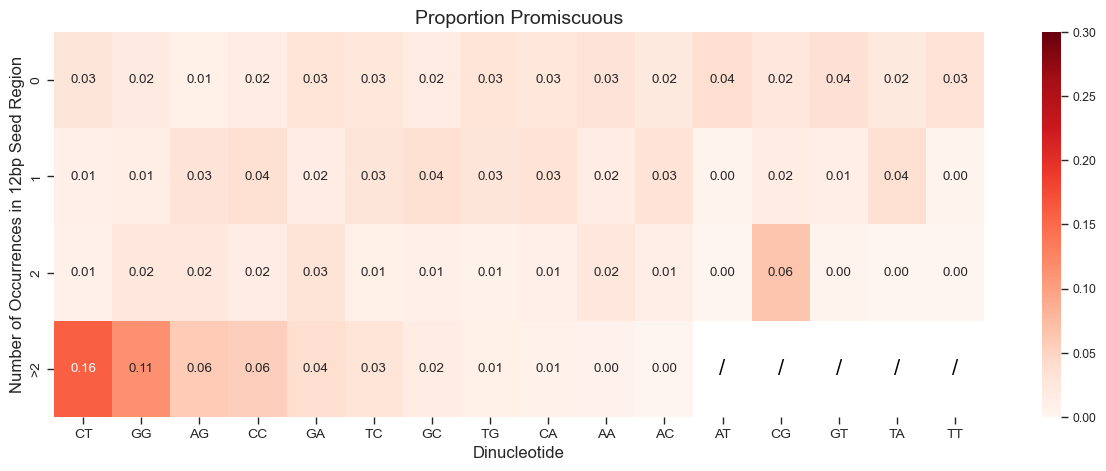

In [12]:
plt.figure(figsize=(15,5))
ax = sns.heatmap(plot_df,cmap='Reds',
               vmin=0, vmax=0.3, annot=True, fmt = '0.2f')
for i in range(plot_df.shape[0]):
    for j in range(plot_df.shape[1]):
        if np.isnan(plot_df.iloc[i, j]):
            ax.text(j + 0.5, i + 0.5, "/", ha='center', va='center', color='black', fontsize=16)
plt.xlabel('Dinucleotide',fontsize=12)
plt.ylabel('Number of Occurrences in 12bp Seed Region',fontsize=12)
plt.title('Proportion Promiscuous', fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

In [16]:
#calculate proportion of guides that are promiscuous for each dinucleotide/count group
plot_df = noness_labeled.melt(id_vars = ['sgRNA Sequence','promiscuous'],
                              var_name = 'Dinucleotide',
                              value_vars = din_list,
                              value_name = 'num_occurrences')

#if we considered all guides with >=0 counts of a certain dinucleotide, we would simply be considering every guide in the dataset
plot_df = plot_df[plot_df['num_occurrences'] > 0].copy()

#bin dinucleotide occurrences to aggregate counts >=3 into one category (for plotting)
bins = [1,2,3,4,np.inf]
labels = ['>=1','>=2','>=3','>=4']
plot_df['num_occurrence_bin'] = pd.cut(plot_df['num_occurrences'], bins = bins, labels = labels, right = False)

#calculate proportion of guides with each count of each dinucleotide that are promiscuous
plot_df = plot_df.groupby(['Dinucleotide',
                           'num_occurrence_bin']).agg(prop_promiscuous = ('promiscuous','mean'),
                                                      sum_promiscuous = ('promiscuous','sum'),
                                                      group_size = ('sgRNA Sequence','count')).reset_index()

#calculate number of guides / promiscuous guides with AT LEAST a certain count of each dinucleotide
plot_df['cumsum_promiscuous'] = plot_df[::-1].groupby('Dinucleotide')['sum_promiscuous'].transform('cumsum')
plot_df['cum_group_size'] = plot_df[::-1].groupby('Dinucleotide')['group_size'].transform('cumsum')

#recalculate proportion of promiscuous guides
plot_df['cumprop_promiscuous'] = plot_df['cumsum_promiscuous']/plot_df['cum_group_size']


#only consider groups with at least 30 guides for consistency with previous plot
plot_df = plot_df[plot_df['cum_group_size'] >= 30].copy()


#implement Fisher Exact test

total_promiscuous = noness_labeled['promiscuous'].sum()
total_nonpromiscuous = (~noness_labeled['promiscuous']).sum()
plot_df.loc[:,'p_value'] = plot_df.apply(lambda row: fisher_exact(np.array([[row['cumsum_promiscuous'],row['cum_group_size']-row['cumsum_promiscuous']],
                                                                  [total_promiscuous,total_nonpromiscuous]]),
                                         alternative = 'greater').pvalue, axis=1)
plot_df.loc[:,'-log(p-value)'] = -np.log10(plot_df.loc[:,'p_value'])

plot_df

,Dinucleotide,num_occurrence_bin,prop_promiscuous,sum_promiscuous,group_size,cumsum_promiscuous,cum_group_size,cumprop_promiscuous,p_value,-log(p-value)
0,AA,>=1,0.015748,12,762,22,1349,0.016308,9.764526e-01,1.034885e-02
1,AA,>=2,0.024000,9,375,10,587,0.017036,9.121714e-01,3.992356e-02
2,AA,>=3,0.007143,1,140,1,212,0.004717,9.949065e-01,2.217716e-03
3,AA,>=4,0.000000,0,72,0,72,0.000000,1.000000e+00,-0.000000e+00
4,AC,>=1,0.033654,42,1248,46,1628,0.028256,2.853859e-01,5.445674e-01
5,AC,>=2,0.012232,4,327,4,380,0.010526,9.836505e-01,7.159164e-03
6,AC,>=3,0.000000,0,49,0,53,0.000000,1.000000e+00,-0.000000e+00
8,AG,>=1,0.031227,42,1345,72,2302,0.031277,9.634078e-02,1.016190e+00
9,AG,>=2,0.024643,19,771,30,957,0.031348,1.712867e-01,7.662763e-01
10,AG,>=3,0.055556,9,162,11,186,0.059140,1.035605e-02,1.984806e+00


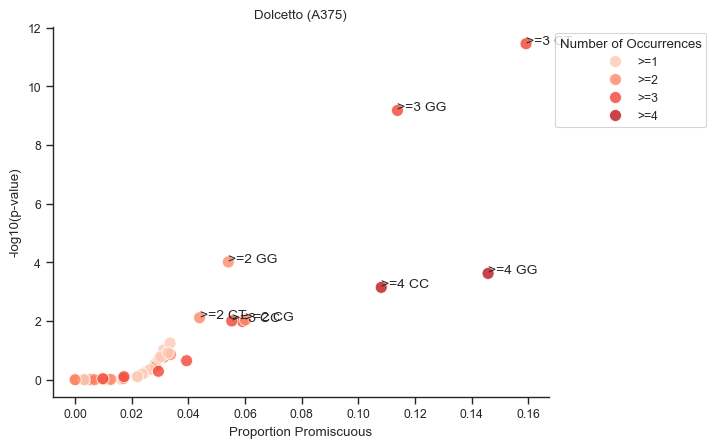

In [17]:
sns.scatterplot(data = plot_df, x = 'cumprop_promiscuous', y = '-log(p-value)', hue = 'num_occurrence_bin',
                palette='Reds', alpha = 0.8, s = 75)

texts = []
for i,row in plot_df.iterrows():
    x = row['cumprop_promiscuous']
    y = row['-log(p-value)']
    din = str(row['Dinucleotide'])
    n = str(row['num_occurrence_bin'])
    if (y > 2):
        text = plt.text(x, y, n + ' ' + din, fontsize=10)
sns.despine()

plt.xlabel('Proportion Promiscuous')
plt.ylabel('-log10(p-value)')
plt.legend(title = 'Number of Occurrences', bbox_to_anchor=(1,1))
plt.title('Dolcetto (A375)')

gpp.savefig("../../Figures/Figure 5/dolcetto_nonessentials_12bp_seed_dinucleotide_count_cutoffs_vs_promiscuity_volcano.pdf",dpi=300, bbox_inches = 'tight')